In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create_engine is the 'method' used for connecting to databases imported from sqlalchemy.orm
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
##Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
##Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)


### Jake: Not sure if this is "reflecting" the database into a new model, but in previous activities, we've connected to the engine and then performed a query using Pandas
### For example:
#conn = engine.connect()
### Run a query using the connected engine and create a pandas dataframe
#data = pd.read_sql("SELECT * FROM hawaii", conn) 
### Note: I *think* that the table name we're querying is called "hawaii"... that's the name of the sqlite file at least.
### Note: now I'm not sure if the name of the sqlite file is representative of the name of the table.. come back to this

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table

##I think we're supposed to do this:
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB

##Create a session
session = Session(engine)


# Exploratory Climate Analysis

In [125]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

##What columns do we have in our database?
first_row = session.query(measurement).first()
first_row.__dict__
## Design the query
#engine.execute('SELECT prcp,date FROM measurement WHERE date BETWEEN 2010-01-01 AND 2010-12-31').fetchall()
#session.query(measurement.date).order_by(measurement.date.desc()).first()
#so 2017-08-23 is the last date. 
#session.query(Dow.date).filter(Dow.date < '2017-08-23').order_by(Dow.date).all()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)
##Query all dates greater than the query_date
precipitation_results = session.query(measurement.prcp,measurement.date).filter(measurement.date > query_date).order_by(measurement.date).all()
#Unpack the `prcp` and `date` from results and save into separate lists
prcp = [result[0] for result in precipitation_results]
date = [result[1] for result in precipitation_results]
#Plot results
# fig, ax = plt.subplots()
# ypos = range(1, len(prcp)+1)
# ax.barh(ypos, prcp[::-1])
# ax.set_xlabel("Precipitation")
# ax.set_ylabel("Date")
# ax.set_yticks(ypos)
# ax.set_yticklabels(date[::-1])
# ax.set_title("Precipitation by Date")
# fig.tight_layout()
# plt.show()
#Fuck matplotlib... use pandas
df = pd.DataFrame(precipitation_results, columns=['Precipitation', 'Date'])
df
df.head().plot.bar(x='Date',y='Precipitation',title="Precipitation by Date")

#### Actual plot is below.. just printed the .head() plot cause it was more readable
#df.plot.bar(x='Date',y='Precipitation',title="Precipitation by Date")
plt.tight_layout()
plt.show()



Query Date:  2016-08-23


,Precipitation,Date
0,0.08,2016-08-24
1,2.15,2016-08-24
2,2.28,2016-08-24
3,NaN,2016-08-24
4,1.22,2016-08-24
...,...,...
2218,0.50,2017-08-22
2219,0.00,2017-08-23
2220,0.00,2017-08-23
2221,0.08,2017-08-23


In [42]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


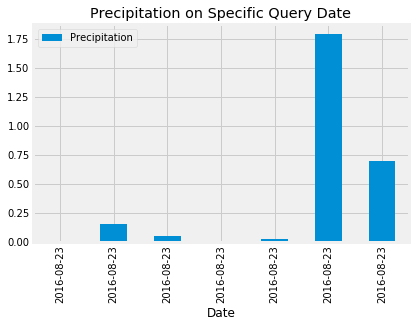

In [50]:
# Perform a query to retrieve the data and precipitation scores
specific_date_results = session.query(measurement.prcp,measurement.date).filter(measurement.date == query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df2 = pd.DataFrame(specific_date_results, columns=['Precipitation', 'Date'])
df2.head()
# Sort the dataframe by date 
#df2 = df2.sort_values

# Use Pandas Plotting with Matplotlib to plot the data
df2.plot.bar(x='Date',y='Precipitation',title="Precipitation on Specific Query Date")


In [51]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#Let's describe all the data
all_data = session.query(measurement.prcp,measurement.date).order_by(measurement.date).all()
all_df = pd.DataFrame(all_data, columns=['Precipitation', 'Date'])
all_df.describe()

#just the data from the last observation to a year before
df.describe()

#Describing the precipitation only on the day a year before the last observation
df2.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [52]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(station).count()
print(f"There are {stations_count} stations available in this dataset.")

There are 9 stations available in this dataset.


In [126]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_query = session.query(station).all()

first_row = session.query(station).first()
first_row.__dict__
first_row = session.query(measurement).first()
first_row.__dict__

station_results = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
#station_results = session.query(measurement.station).group_by(measurement.station).count()
#station_results = engine.execute('SELECT station,count(station) FROM measurement GROUP BY station')
for result in station_results:
    print(result)
    

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [91]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

## I'm not sure which variable is supposed to be temperature???? assuming it's 'tobs' cause none of the other data makes sense
station_max_temp = session.query(measurement.tobs).filter(measurement.station=='USC00519281').all()
station_max_temp_df = pd.DataFrame(station_max_temp)
station_max_temp_df.describe()

print('The minimum temperature at station USC00519281 was 54, the max was 85, and the mean was 71.66.')

The minimum temperature at station USC00519281 was 54, the max was 85, and the mean was 71.66.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000251FCC19088>]],
      dtype=object)

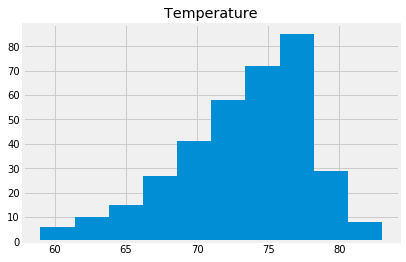

In [98]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_results2 = session.query(measurement.station,func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.tobs)).all()
station_results2

temp_results = session.query(measurement.tobs,measurement.date).filter(measurement.date > query_date).filter(measurement.station=='USC00519281').order_by(measurement.date).all()
temp_df = pd.DataFrame(temp_results,columns=['Temperature','Date'])
temp_df.head(20)
temp_df.hist()

## Bonus Challenge Assignment

In [100]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [107]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#My trip dates - July 15th - July 18th 2017  ---> So we're using 2016-07-15 and 2016-07-18 for the 'calc_temps' function
last_years_temps = calc_temps('2016-07-15','2016-07-18')
last_years_temps
min_temp = last_years_temps[0][0]
avg_temp = last_years_temps[0][1]
max_temp = last_years_temps[0][2]
last_year_df = pd.DataFrame([min_temp,avg_temp,max_temp],['Minimum Temperature','Average Temperature','Max Temperature'])
last_year_df

,0
Minimum Temperature,71.00
Average Temperature,76.88
Max Temperature,82.00


11.0

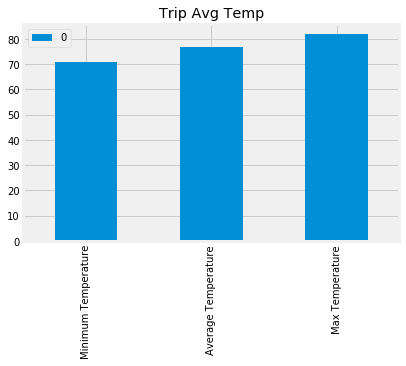

In [109]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
last_year_df.plot.bar(title='Trip Avg Temp')
yerr = max_temp-min_temp
yerr

In [121]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

why_am_I_still_doing_the_bonus = session.query(measurement.station,measurement.prcp).filter(measurement.date > '2016-07-14').filter(measurement.date < '2016-07-19').group_by(measurement.station).order_by(measurement.prcp).all()
print(why_am_I_still_doing_the_bonus)

lat_long_ele_whatever = session.query(station.elevation,station.latitude,station.longitude,station.id).group_by(station.id).all()
lat_long_ele_whatever

# heres_a_data_frame = pd.DataFrame({'ID':lat_long_ele_whatever[3],'Station':why_am_I_still_doing_the_bonus[0],'Precipitation':why_am_I_still_doing_the_bonus[1],'Elevation':lat_long_ele_whatever[0],'Lat':lat_long_ele_whatever[1],'Lng':lat_long_ele_whatever[2]})
# heres_a_data_frame.head()

[('USC00517948', None), ('USC00519281', 0.14), ('USC00513117', 0.23), ('USC00519523', 0.42), ('USC00514830', 0.43), ('USC00519397', 0.46), ('USC00516128', 1.7)]


(3.0, 21.2716, -157.8168, 1)

In [114]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x251f5916e48>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
